Let's see if we can create a model to predict if a coin will
1. go up by 1%
2. trade in the same zone
3. go down by 1%
in the next 2 hours (12 5m candles)

on CDC exchange, fees are 0.4% per transaction, so we should aim to make at least 0.2% profit on each trade

In [80]:
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, ShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ta.momentum import rsi
from ta.trend import sma_indicator
import xgboost as xgb


from cdc_wrapper import CDC

In [2]:
with open('keys.json', 'r') as f:
    keys = json.load(f)

cdc = CDC(keys, sandbox=False)

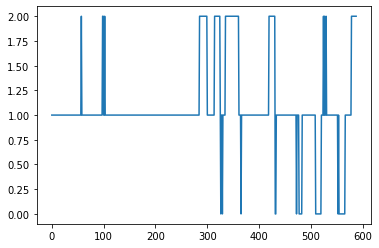

In [44]:
data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(data)

future_window = 12
future_diff_threshold = 0.012

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 1
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 0
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 1

df = df[['c', 'label']]

y = df['label'].values

plt.plot(y)

Let's focus on ETH USDC

In [34]:
data_file_name = 'data2.csv'
instrument = 'BTC_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

# technical analysis params
rsi_windows = [5, 7]
sma_windows = [5, 8, 13]

# load in and drop duplicates
df = pd.read_csv(data_file_name).drop_duplicates()

# we are streaming data in through the websocket so we only need the latest row 
df = df.groupby(['instrument', 't']).last().reset_index()

# filter for ETH USDC
df = df.loc[df['instrument']==instrument]

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold



df['label'] = 0
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 1
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 0

# now that we have the labels, we can remove the future values and clean up a bit...

df = df[['dt', 'o', 'h', 'l', 'c', 'v', 'label']]

df = df.set_index('dt')

for w in rsi_windows:
    df[f'rsi{w}'] = rsi(df['c'], window=w)

for w in sma_windows:
    df[f'sma{w}'] = sma_indicator(df['c'], window=w)



X_cols = [col for col in df.columns if col != 'label']
# # let's bring in the past values

for i in range(1, past_window+1):
    for col in X_cols:
        df[f'{col}_{i}'] = df[col].shift(i)


# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
df = df.dropna()


# scaler = MinMaxScaler()
# X = df.drop(['dt', 'label'], axis=1).values
# y = df['label'].values

# scaler.fit(X)

# scaler.transform(X)

df

C:\Users\cetyz\AppData\Local\Temp\ipykernel_29256\623405285.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{i}'] = df[col].shift(i)
C:\Users\cetyz\AppData\Local\Temp\ipykernel_29256\623405285.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{i}'] = df[col].shift(i)
C:\Users\cetyz\AppData\Local\Temp\ipykernel_29256\623405285.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

,o,h,l,c,v,label,rsi5,rsi7,sma5,sma8,...,o_24,h_24,l_24,c_24,v_24,rsi5_24,rsi7_24,sma5_24,sma8_24,sma13_24
dt,,,,,,,,,,,,,,,,,,,,,
2022-07-09 08:35:00,21645.49,21661.70,21639.29,21656.35,0.510084,0,59.820762,58.852986,21637.192,21634.36000,...,21514.19,21526.27,21506.00,21515.04,0.334715,60.183194,60.012092,21511.904,21505.47750,21502.113077
2022-07-09 08:40:00,21655.66,21670.35,21623.69,21664.65,0.472203,0,63.163305,61.232828,21651.000,21639.52875,...,21520.13,21548.59,21516.55,21533.31,0.827951,72.495962,69.933427,21516.222,21511.32375,21505.446923
2022-07-09 08:45:00,21665.22,21717.34,21658.84,21689.57,0.383206,0,71.927875,67.763706,21662.048,21647.89625,...,21534.59,21552.09,21525.49,21537.91,2.348366,74.935346,71.975825,21520.214,21516.40500,21508.640769
2022-07-09 08:50:00,21688.30,21701.91,21647.83,21701.24,0.795591,0,75.359725,70.480668,21670.416,21655.17750,...,21540.09,21554.94,21537.29,21543.55,0.588047,77.934683,74.457723,21529.420,21521.78625,21511.536923
2022-07-09 08:55:00,21696.67,21715.14,21680.83,21704.79,0.880061,0,76.454268,71.338000,21683.320,21668.82500,...,21546.85,21560.32,21538.68,21546.70,0.769490,79.635938,75.851277,21535.302,21526.15875,21515.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12 07:10:00,19750.25,19791.26,19644.97,19669.69,13.081472,0,20.738013,22.960893,19757.420,19794.28750,...,19997.66,20003.10,19984.42,19990.73,0.348696,66.078122,66.472773,19987.926,19984.47000,19977.041538
2022-07-12 07:15:00,19666.46,19673.67,19591.00,19655.58,9.311480,0,19.369542,21.816498,19723.836,19769.22500,...,19993.68,19993.68,19972.29,19985.49,0.317289,55.882870,60.204983,19988.560,19987.87750,19980.001538
2022-07-12 07:20:00,19662.24,19687.55,19621.62,19640.68,1.296984,0,17.817562,20.554385,19686.544,19739.22125,...,19987.92,20026.86,19977.63,20020.88,0.569775,80.840010,77.168169,19995.872,19992.51750,19985.384615


will need to kfold because rows near to each other might be highly correlated??

In [79]:
# balance classes

df2 = df.copy()

scaler = MinMaxScaler()

X_cols = [col for col in df2.columns if col != 'label']
y_col = 'label'

X = df2[X_cols]
y = df2[y_col]

X = scaler.fit_transform(X)

param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['nthread'] = 6
param['num_class'] = 3

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=0
# )

rskf = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=0)

error_rates = []

for train_index, test_index in rskf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )

    xg_train = xgb.DMatrix(X_train, label=y_train, weight=weights)
    xg_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 5
    bst = xgb.train(param, xg_train, num_round, watchlist)
    # get prediction
    pred = bst.predict(xg_test)
    error_rate = np.sum(pred != y_test) / y_test.shape[0]
    error_rates.append(error_rate)
    # print('Test error using softmax = {}'.format(error_rate))

print('Overall mean error rate:', np.mean(error_rates))

print(confusion_matrix(y_test, pred))

# will use train test split for convenience
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=np.round(1/6, 2), random_state=0
)



weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_test
)

xg = xgb.DMatrix(X_test, label=y_test, weight=weights)
watchlist = [(xg, 'final')]
num_round=5
bst = xgb.train(param, xg, num_round, watchlist)

[0]	train-mlogloss:0.99042	test-mlogloss:1.01825
[1]	train-mlogloss:0.89757	test-mlogloss:0.94696
[2]	train-mlogloss:0.81637	test-mlogloss:0.88556
[3]	train-mlogloss:0.74298	test-mlogloss:0.82758
[4]	train-mlogloss:0.67915	test-mlogloss:0.77821
[0]	train-mlogloss:0.98467	test-mlogloss:1.02905
[1]	train-mlogloss:0.88260	test-mlogloss:0.95621
[2]	train-mlogloss:0.79607	test-mlogloss:0.89427
[3]	train-mlogloss:0.72021	test-mlogloss:0.84361
[4]	train-mlogloss:0.65660	test-mlogloss:0.80061


c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[0]	train-mlogloss:0.98286	test-mlogloss:1.02713
[1]	train-mlogloss:0.88583	test-mlogloss:0.97350
[2]	train-mlogloss:0.80026	test-mlogloss:0.91825
[3]	train-mlogloss:0.72840	test-mlogloss:0.87703
[4]	train-mlogloss:0.66368	test-mlogloss:0.83883
[0]	train-mlogloss:0.98583	test-mlogloss:1.01821
[1]	train-mlogloss:0.89054	test-mlogloss:0.95211
[2]	train-mlogloss:0.80468	test-mlogloss:0.89325
[3]	train-mlogloss:0.73037	test-mlogloss:0.84679
[4]	train-mlogloss:0.66752	test-mlogloss:0.80235
[0]	train-mlogloss:0.98437	test-mlogloss:1.02849
[1]	train-mlogloss:0.88672	test-mlogloss:0.96342
[2]	train-mlogloss:0.79871	test-mlogloss:0.90008
[3]	train-mlogloss:0.72328	test-mlogloss:0.84759
[4]	train-mlogloss:0.65834	test-mlogloss:0.80934
[0]	train-mlogloss:0.98851	test-mlogloss:1.03204
[1]	train-mlogloss:0.89395	test-mlogloss:0.96425
[2]	train-mlogloss:0.80604	test-mlogloss:0.89677
[3]	train-mlogloss:0.72958	test-mlogloss:0.84014
[4]	train-mlogloss:0.66130	test-mlogloss:0.78757
[0]	train-mlogloss:0

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[4]	train-mlogloss:0.65954	test-mlogloss:0.80847
[0]	train-mlogloss:0.98734	test-mlogloss:1.02474
[1]	train-mlogloss:0.89022	test-mlogloss:0.96134
[2]	train-mlogloss:0.80862	test-mlogloss:0.90627
[3]	train-mlogloss:0.73620	test-mlogloss:0.85971
[4]	train-mlogloss:0.67431	test-mlogloss:0.81866
[0]	train-mlogloss:0.98675	test-mlogloss:1.03486
[1]	train-mlogloss:0.88924	test-mlogloss:0.96958
[2]	train-mlogloss:0.80617	test-mlogloss:0.91950
[3]	train-mlogloss:0.73378	test-mlogloss:0.87747
[4]	train-mlogloss:0.66805	test-mlogloss:0.83530
[0]	train-mlogloss:0.98275	test-mlogloss:1.02109
[1]	train-mlogloss:0.88428	test-mlogloss:0.95373
[2]	train-mlogloss:0.79729	test-mlogloss:0.89667
[3]	train-mlogloss:0.72276	test-mlogloss:0.84696
[4]	train-mlogloss:0.65763	test-mlogloss:0.80088
[0]	train-mlogloss:0.98683	test-mlogloss:1.02574
[1]	train-mlogloss:0.88940	test-mlogloss:0.96180
[2]	train-mlogloss:0.80627	test-mlogloss:0.90530
[3]	train-mlogloss:0.73753	test-mlogloss:0.86745
[4]	train-mlogloss:0

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[0]	train-mlogloss:0.98937	test-mlogloss:1.03222
[1]	train-mlogloss:0.89519	test-mlogloss:0.97491
[2]	train-mlogloss:0.80788	test-mlogloss:0.91826
[3]	train-mlogloss:0.73768	test-mlogloss:0.87558
[4]	train-mlogloss:0.67024	test-mlogloss:0.83263
[0]	train-mlogloss:0.98101	test-mlogloss:0.99892
[1]	train-mlogloss:0.87506	test-mlogloss:0.91200
[2]	train-mlogloss:0.78329	test-mlogloss:0.83572
[3]	train-mlogloss:0.70525	test-mlogloss:0.76801
[4]	train-mlogloss:0.63755	test-mlogloss:0.71033
[0]	train-mlogloss:0.98864	test-mlogloss:1.02510
[1]	train-mlogloss:0.90022	test-mlogloss:0.96193
[2]	train-mlogloss:0.81943	test-mlogloss:0.90388
[3]	train-mlogloss:0.74877	test-mlogloss:0.85497
[4]	train-mlogloss:0.68242	test-mlogloss:0.80805
[0]	train-mlogloss:0.98458	test-mlogloss:1.03683
[1]	train-mlogloss:0.88870	test-mlogloss:0.98281
[2]	train-mlogloss:0.80317	test-mlogloss:0.93316
[3]	train-mlogloss:0.72853	test-mlogloss:0.88724
[4]	train-mlogloss:0.66210	test-mlogloss:0.84154
Overall mean error r

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


In [76]:
windows = max(rsi_windows + sma_windows)

testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=windows+future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')
results_df = testing_df.copy()[-future_window:]
print(results_df['l'].min(), results_df['h'].max())
testing_df = testing_df[:-future_window]



testing_df = testing_df.set_index('dt')
testing_df = testing_df.drop('t', axis=1)

for w in rsi_windows:
    testing_df[f'rsi{w}'] = rsi(testing_df['c'], window=w)

for w in sma_windows:
    testing_df[f'sma{w}'] = sma_indicator(testing_df['c'], window=w)



X_cols = [col for col in testing_df.columns if col != 'label']
# # let's bring in the past values

dfs = [testing_df]

for i in range(1, past_window+1):

    dataframe = testing_df.copy().shift(i)
    new_cols = [f'{col}_{i}' for col in dataframe.columns]
    dataframe.columns = new_cols
    dfs.append(dataframe)
    # for col in X_cols:
    #     testing_df[f'{col}_{i}'] = testing_df[col].shift(i)

testing_df = pd.concat(dfs, axis=1)

testing_df

# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
testing_df = testing_df.dropna()

X = testing_df

X = scaler.transform(X)

X = xgb.DMatrix(X)

bst.predict(X)

19538.76 19773.45


array([0.], dtype=float32)

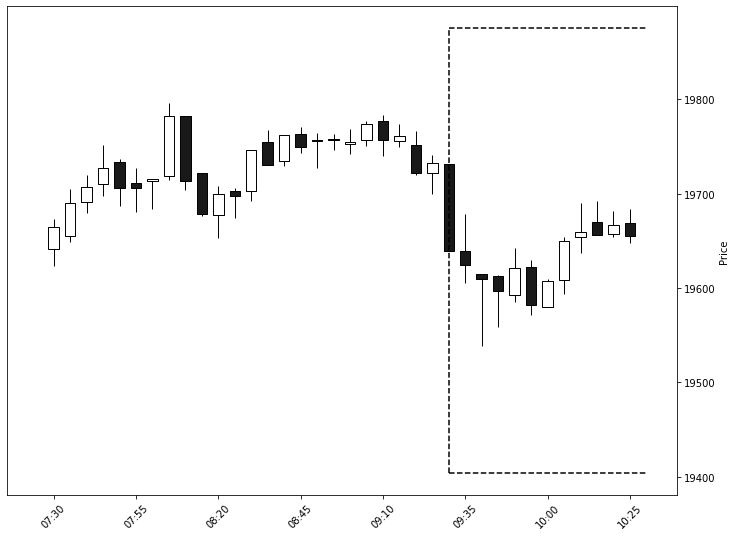

In [77]:
testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')

testing_df = testing_df.drop('t', axis=1).set_index('dt').rename({'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12,9))

mpl.plot(
    testing_df,
    type='candle',
    style='classic',
    ax=ax
)

plt.sca(ax)

vline_y_min = min(testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), testing_df['Low'].min())
vline_y_max = max(testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), testing_df['High'].max())

plt.vlines(x=past_window, ymin=vline_y_min, ymax=vline_y_max, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')

plt.show()